In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

## Prepare Dataset

In [2]:
# Get Apple finance data from yfinance
df = yf.download('AAPL', start='2015-01-01', end=None)

[*********************100%%**********************]  1 of 1 completed


In [3]:
# Fill missing dates with previous date
df = df.reindex(pd.date_range(df.index[0], df.index[-1], freq='D'), method='ffill')
# Drop adj close and volume columns
df.drop(columns = ["Adj Close", "Volume"], inplace=True)

In [4]:
df

,Open,High,Low,Close
2015-01-02,27.847500,27.860001,26.837500,27.332500
2015-01-03,27.847500,27.860001,26.837500,27.332500
2015-01-04,27.847500,27.860001,26.837500,27.332500
2015-01-05,27.072500,27.162500,26.352501,26.562500
2015-01-06,26.635000,26.857500,26.157499,26.565001
...,...,...,...,...
2023-09-01,189.490005,189.919998,188.279999,189.460007
2023-09-02,189.490005,189.919998,188.279999,189.460007
2023-09-03,189.490005,189.919998,188.279999,189.460007
2023-09-04,189.490005,189.919998,188.279999,189.460007


In [5]:
df.describe()

,Open,High,Low,Close
count,3169.000000,3169.000000,3169.000000,3169.000000
mean,80.308415,81.187872,79.450709,80.365034
std,53.622687,54.259902,53.018769,53.678386
min,22.500000,22.917500,22.367500,22.584999
25%,34.695000,34.840000,34.647499,34.750000
50%,51.757500,52.185001,51.130001,51.812500
75%,134.350006,135.529999,133.229996,134.509995
max,196.240005,198.229996,195.279999,196.449997


In [6]:
import matplotlib.pyplot as plt

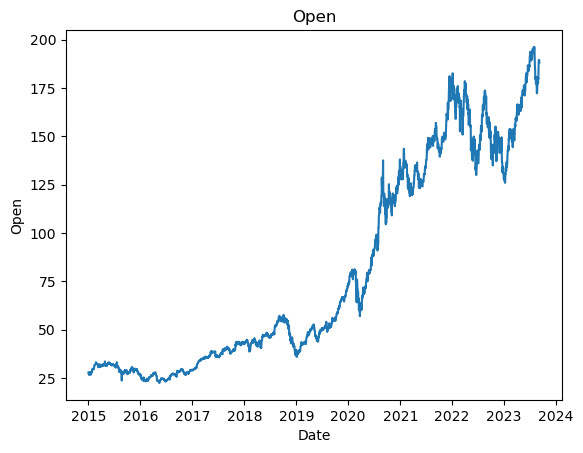

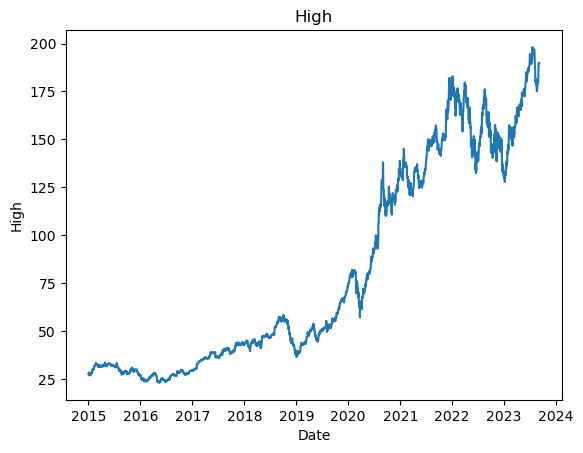

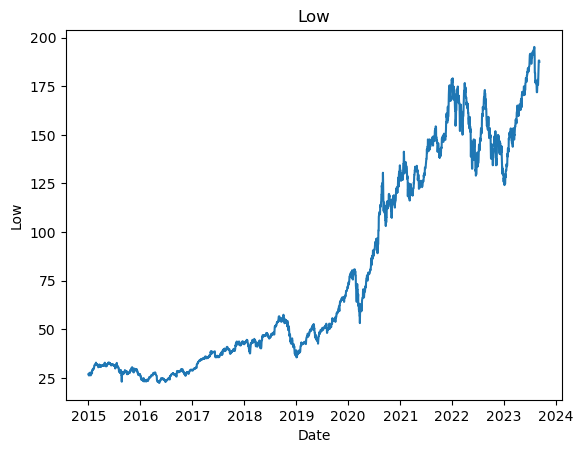

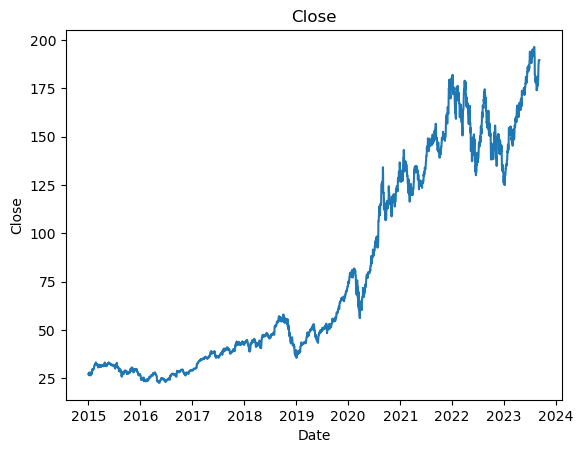

In [7]:
# Plot each column over time
for label in df.columns:
    plt.plot(df.index, df[label])
    plt.title(label)
    plt.xlabel("Date")
    plt.ylabel(label)
    plt.show()

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
scaler = MinMaxScaler()

In [10]:
# scale data
def scale_df(df_to_scale, scaler_to_use):
    return_df_scaled = scaler_to_use.fit_transform(df_to_scale)
    return return_df_scaled

# training data: 70%, validation data: 20%, test data: 10%
def split_data(df_to_split_data):
    train, valid, test = np.split(df_to_split_data, [int(.7*len(df_to_split_data)), int(.9*len(df_to_split_data))])
    return train, valid, test

# split into x (feature) and y (label)
def split_xy(df_to_split_xy, ws):
    x = []
    y = []
    for i in range(len(df_to_split_xy) - ws):
        row = [a for a in df_to_split_xy[i:i+ws]]
        x.append(row)
        y.append(df_to_split_xy[i+ws])
    return np.array(x), np.array(y)

In [11]:
# use 'close' column
df = df[["Close"]]
# scale df
scaled_df_np = scale_df(df, scaler)
# split df
train, valid, test = split_data(scaled_df_np)
# split into x and y
window_size = 60 # predict by past 60 days
x_train, y_train = split_xy(train, window_size)
x_valid, y_valid = split_xy(valid, window_size)
x_test, y_test = split_xy(test, window_size)

## Build Model

In [12]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

In [13]:
def model_builder(hp):
    model = keras.Sequential()
    # input x
    model.add(keras.layers.InputLayer(input_shape=(x_train.shape[-2], x_train.shape[-1])))
    
    # lstm
    model.add(keras.layers.LSTM(100, return_sequences=True))
    model.add(keras.layers.LSTM(100, return_sequences=False))
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 20-30
    hp_units = hp.Int('units', min_value=20, max_value=30, step=2)
    model.add(keras.layers.Dense(units=hp_units, activation='linear'))
    
    # output
    model.add(keras.layers.Dense(x_train.shape[-1], activation='linear'))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])
    
    # compile
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.MeanSquaredError(), metrics=[keras.metrics.RootMeanSquaredError()])
    
    return model

In [14]:
tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective(keras.metrics.RootMeanSquaredError().name, 'min'),
                     max_epochs=50,
                     factor=5,
                     directory='hypertuning_trials',)

INFO:tensorflow:Reloading Tuner from hypertuning_trials\untitled_project\tuner0.json


In [15]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=5)
tuner.search(x_train, y_train, validation_data=(x_valid, y_valid), callbacks=[stop_early])

INFO:tensorflow:Oracle triggered exit


In [16]:
best_model = tuner.get_best_models()[0]

In [17]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 26)                2626      
                                                                 
 dense_1 (Dense)             (None, 1)                 27        
                                                                 
Total params: 123853 (483.80 KB)
Trainable params: 123853 (483.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
best_model.get_compile_config()

{'optimizer': {'module': 'keras.optimizers',
  'class_name': 'Adam',
  'config': {'name': 'Adam',
   'weight_decay': None,
   'clipnorm': None,
   'global_clipnorm': None,
   'clipvalue': None,
   'use_ema': False,
   'ema_momentum': 0.99,
   'ema_overwrite_frequency': None,
   'jit_compile': False,
   'is_legacy_optimizer': False,
   'learning_rate': 0.009999999776482582,
   'beta_1': 0.9,
   'beta_2': 0.999,
   'epsilon': 1e-07,
   'amsgrad': False},
  'registered_name': None},
 'loss': {'module': 'keras.losses',
  'class_name': 'MeanSquaredError',
  'config': {'reduction': 'auto',
   'name': 'mean_squared_error',
   'fn': 'mean_squared_error'},
  'registered_name': None},
 'metrics': [{'module': 'keras.metrics',
   'class_name': 'RootMeanSquaredError',
   'config': {'name': 'root_mean_squared_error', 'dtype': 'float32'},
   'registered_name': None}],
 'loss_weights': None,
 'weighted_metrics': None,
 'run_eagerly': None,
 'steps_per_execution': None,
 'jit_compile': None}

In [19]:
eval_result = best_model.evaluate(x_test, y_test)
print("[test loss, test accuracy (rmse)]:", eval_result)

9/9 [==============================] - 1s 24ms/step - loss: 3.3841e-04 - root_mean_squared_error: 0.0184
[test loss, test accuracy (rmse)]: [0.00033840577816590667, 0.018395809456706047]


## Test

In [20]:
# y_pred for y_test
y_pred = best_model.predict(x_test)
# unscale
y_pred = scaler.inverse_transform(y_pred)

9/9 [==============================] - 1s 24ms/step


In [21]:
test_df = pd.DataFrame(df[-y_test.shape[0]:])
test_df["Predictions"] = y_pred

In [22]:
rmse = np.sqrt(np.mean(y_pred - y_test)**2)
rmse

164.9345787792372

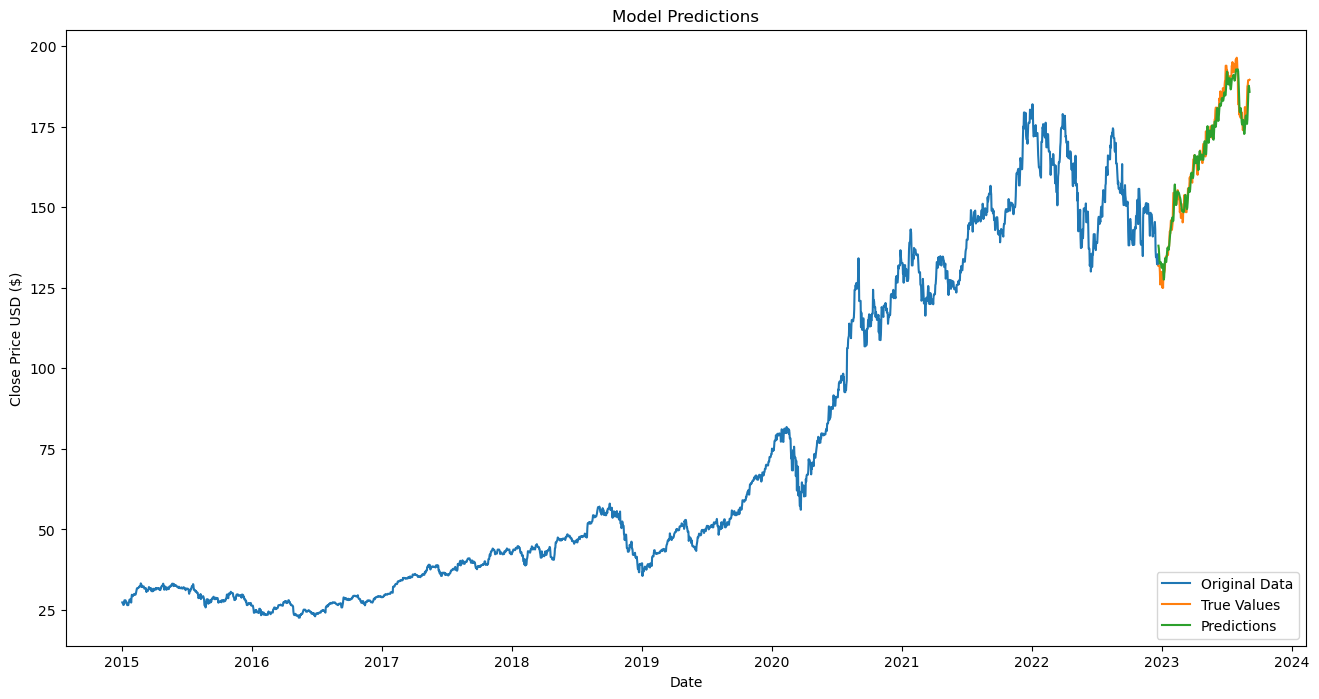

In [23]:
plt.figure(figsize=(16,8))
plt.title('Model Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(df[:-y_test.shape[0]])
plt.plot(test_df[['Close', 'Predictions']])
plt.legend(['Original Data', 'True Values', 'Predictions'], loc='lower right')
plt.show()

In [24]:
# best_model.save('yfts_best_model.keras')

## Predict

In [25]:
# yfts_best_model = keras.models.load_model('yfts_best_model.keras')

In [26]:
# df until 2020
chart_df = pd.DataFrame(df.copy().loc[:pd.to_datetime('2023-01-01')])

In [27]:
# last 30(ws) available datapoints
future_df = pd.DataFrame(chart_df[-window_size:])

In [28]:
from datetime import timedelta

In [29]:
def predict_next_year(future_df, target, window_size):
#     scale dataset
#     future_scaler = MinMaxScaler()
    scaled_future_df = future_scaler.fit_transform(future_df) # numpy
    target_range = (target - future_df.index[-1]).days # number of days
    
    for i in range(target_range):
        # last 30(ws) entries
        x_data = scaled_future_df[-window_size:].reshape(-1, window_size, 1)
        
        # predict
        future_y_pred = best_model.predict_step(x_data)
        
        # send scaled prediction to scaled dataset
        scaled_future_df = np.vstack([scaled_future_df, future_y_pred[0]])
        print(str(i) + '/' + str(target_range))

    # unscale scaled dataset
    scaled_future_df = future_scaler.inverse_transform(scaled_future_df[window_size:])
    
    # add unscaled dataset to df
    for i in scaled_future_df:
            new_index = future_df.index[-1] + timedelta(days=1)
            future_df.loc[new_index] = i
            
    # remove first 30(ws) of df
    future_df = pd.DataFrame(future_df[window_size:])
    
    
#     while future_df.index[-1] != target:
#         # get last 30(ws) days
#         x_data = scaler.transform(pd.DataFrame(future_df[-window_size:])).reshape(-1, window_size, 1)

#         # predict next day
#         future_y_pred = best_model.predict_step(x_data)
#         future_y_pred = scaler.inverse_transform(future_y_pred)

#         # add next day to df
#         for i in future_y_pred:
#             new_index = future_df.index[-1] + timedelta(days=1)
#             future_df.loc[new_index] = i
            
#         print(new_index)
#     future_df = pd.DataFrame(future_df[window_size:])
    
    
    return future_df

In [30]:
target = future_df.index[-1]
target = target.replace(year=target.year + 1)

In [31]:
target

Timestamp('2024-01-01 00:00:00', freq='D')

In [32]:
# future_scaler = MinMaxScaler()

In [33]:
future_df = predict_next_year(future_df, target, window_size)

0/365
1/365
2/365
3/365
4/365
5/365
6/365
7/365
8/365
9/365
10/365
11/365
12/365
13/365
14/365
15/365
16/365
17/365
18/365
19/365
20/365
21/365
22/365
23/365
24/365
25/365
26/365
27/365
28/365
29/365
30/365
31/365
32/365
33/365
34/365
35/365
36/365
37/365
38/365
39/365
40/365
41/365
42/365
43/365
44/365
45/365
46/365
47/365
48/365
49/365
50/365
51/365
52/365
53/365
54/365
55/365
56/365
57/365
58/365
59/365
60/365
61/365
62/365
63/365
64/365
65/365
66/365
67/365
68/365
69/365
70/365
71/365
72/365
73/365
74/365
75/365
76/365
77/365
78/365
79/365
80/365
81/365
82/365
83/365
84/365
85/365
86/365
87/365
88/365
89/365
90/365
91/365
92/365
93/365
94/365
95/365
96/365
97/365
98/365
99/365
100/365
101/365
102/365
103/365
104/365
105/365
106/365
107/365
108/365
109/365
110/365
111/365
112/365
113/365
114/365
115/365
116/365
117/365
118/365
119/365
120/365
121/365
122/365
123/365
124/365
125/365
126/365
127/365
128/365
129/365
130/365
131/365
132/365
133/365
134/365
135/365
136/365
137/365
138/36

In [34]:
future_df

,Close
2023-01-02,129.908435
2023-01-03,130.605073
2023-01-04,131.066009
2023-01-05,131.085402
2023-01-06,130.852874
...,...
2023-12-28,147.231994
2023-12-29,147.232086
2023-12-30,147.232171
2023-12-31,147.232257


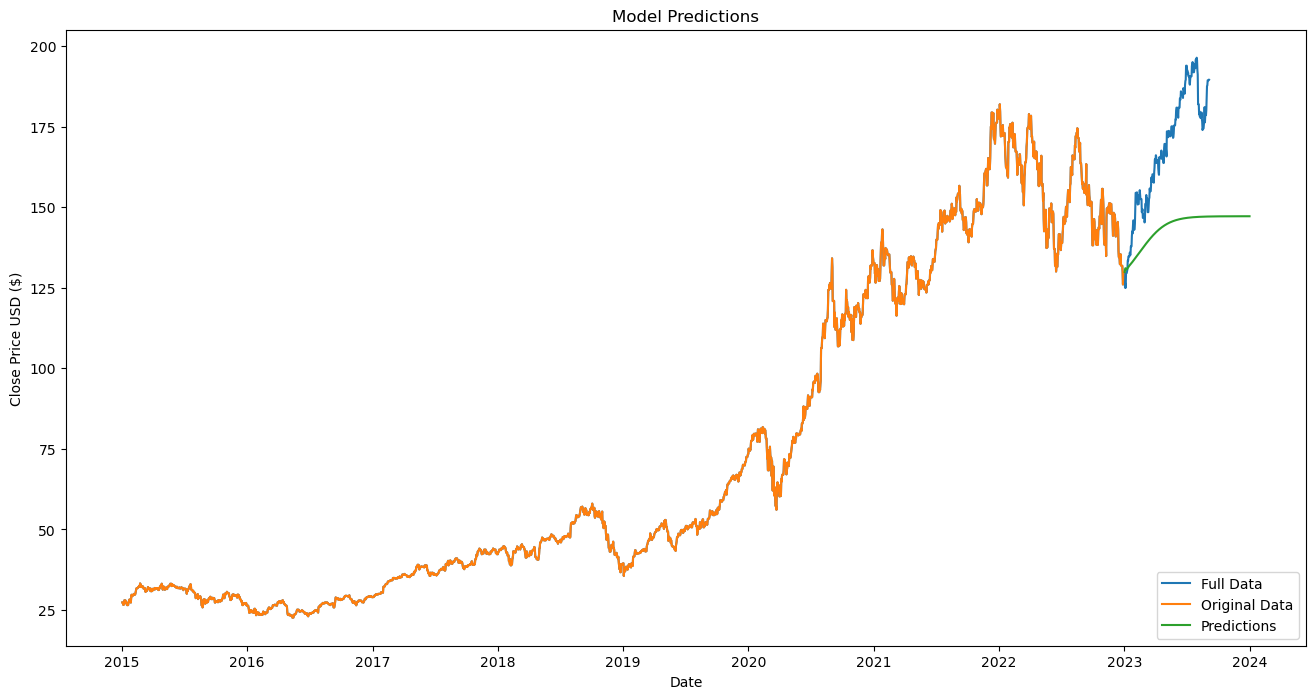

In [35]:
plt.figure(figsize=(16,8))
plt.title('Model Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(df)
plt.plot(chart_df)
plt.plot(future_df)
plt.legend(['Full Data', 'Original Data', 'Predictions'], loc='lower right')
plt.show()